# Cincinnati Reds Analytics Trainee Take Home Assessment
Timothy Clay                          
October 28th, 2024

This file contains all the necessary code to train my models that predict pitch mix distributions and to generate those predictions themselves. I tried to document my work as much as possible, but if there are any outstanding questions, please reach out to me at clay.t@northeastern.edu. 
### Table of Contents
- [Data Processing / Feature Engineering](#section1)
    - [Data Inspection](#subsection1)
    - [Data Cleaning](#subsection2)
- [Model Creation](#section2)
- [Predictions Generation](#section3)

In [1]:
import pandas as pd
import numpy as np
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, root_mean_squared_error
from sklearn.model_selection import GridSearchCV

In [2]:
df = pd.read_csv('data.csv')

In [3]:
df.head()

,PITCH_TYPE,PITCH_NAME,PLAYER_NAME,BATTER_ID,PITCHER_ID,BAT_SIDE,THROW_SIDE,GAME_PK,GAME_YEAR,GAME_DATE,...,HOME_SCORE,AWAY_SCORE,BAT_SCORE,FLD_SCORE,POST_AWAY_SCORE,POST_HOME_SCORE,POST_BAT_SCORE,POST_FLD_SCORE,DELTA_HOME_WIN_EXP,DELTA_RUN_EXP
0,FF,4-Seam Fastball,"Betts, Mookie",605141,608566,R,R,634615,2021,2021-04-01,...,0,0,0,0,0,0,0,0,0.0,0.038
1,FF,4-Seam Fastball,"Betts, Mookie",605141,608566,R,R,634615,2021,2021-04-01,...,0,0,0,0,0,0,0,0,0.0,-0.049
2,FF,4-Seam Fastball,"Betts, Mookie",605141,608566,R,R,634615,2021,2021-04-01,...,0,0,0,0,0,0,0,0,0.0,0.052
3,FF,4-Seam Fastball,"Betts, Mookie",605141,608566,R,R,634615,2021,2021-04-01,...,0,0,0,0,0,0,0,0,0.0,0.113
4,FF,4-Seam Fastball,"Betts, Mookie",605141,608566,R,R,634615,2021,2021-04-01,...,0,0,0,0,0,0,0,0,0.0,-0.077


<a id='section1'></a>
# Data Processing / Feature Engineering
The first step is to aggregate the data on the player and season level. This includes getting the percentage of pitch types that the batter sees in each year, but also computing various statistics. The code cells below walk through the steps I took to compute each of these values and save them in a dataframe. 

In [4]:
# create map to classify pitches as fastballs, offspeed, or breaking pitches
pitch_map = {'FF':'FB', 'SI':'FB', 'FC':'FB', 
             'CH':'OS', 'FS':'OS', 'FO':'OS', 'SC':'OS',
             'CU':'BB', 'KC':'BB', 'CS':'BB', 'SL':'BB', 'ST':'BB',  'SV':'BB', 'KN':'BB'}

# create new column with pitch classification
df['PITCH_CLASS'] = df['PITCH_TYPE'].map(pitch_map)

In [5]:
# create binary variables for whether the batter swings, whether the batter whiffs, and whether the pitch was in the strike zone
df['SWING'] = np.where(df['DESCRIPTION'].isin(['foul', 'hit_into_play', 'swinging_strike', 'swinging_strike_blocked', 'foul_tip']), 1, 0)
df['WHIFF'] = np.where(df['DESCRIPTION'].isin(['swinging_strike', 'swinging_strike_blocked', 'foul_tip']), 1, 0)
df['STRIKE'] = np.where((df['PLATE_X'] <= 0.83) & (df['PLATE_X'] >= -0.83) & (df['PLATE_Z'] <= df['SZ_TOP']) & (df['PLATE_Z'] >= df['SZ_BOT']), 1, 0)

In [6]:
# group hitters by batting handedness
bat_sides = df.groupby(['BATTER_ID', 'BAT_SIDE']).size().reset_index().groupby(['BATTER_ID'])['BAT_SIDE'].count().reset_index()

# if hitter appears as both RHH and LHH, classifies them as switch hitter
bat_sides.loc[bat_sides['BAT_SIDE']==1, 'BAT_SIDE'] = np.nan
bat_sides.loc[bat_sides['BAT_SIDE']==2, 'BAT_SIDE'] = 'S'

# add the hitter handedness information to original dataframe
df = df.merge(bat_sides.rename(columns={'BAT_SIDE':'hits'}), on=['BATTER_ID'])

# if the hitter is not a switch hitter, just use their BAT_SIDE value
df['hits'] = np.where(df['hits'].isna(), df['BAT_SIDE'], df['hits'])

In [7]:
# groups the data by batter and by year

# gets the number of pitches seen by the batter
pitch_mix_df = df.groupby(['BATTER_ID', 'GAME_YEAR'])['PITCH_CLASS'].count().reset_index().rename(columns={'PITCH_CLASS':'Pitches_seen'})

# gets the batter's swing rate
swing_rates_df = df.groupby(['BATTER_ID', 'GAME_YEAR'])['SWING'].mean().reset_index().rename(columns={'SWING':'swing%'})

# gets the whiff rate of the batter
whiff_rates_df = df.loc[df['SWING']==1].groupby(['BATTER_ID', 'GAME_YEAR'])['WHIFF'].mean().reset_index().rename(columns={'WHIFF':'whiff%'})

# gets the batter's o-swing rate
oswing_df = df.loc[df['STRIKE']==0].groupby(['BATTER_ID', 'GAME_YEAR'])['SWING'].mean().reset_index().rename(columns={'SWING':'oswing%'})

# gets the batter's z-swing rate
zswing_df = df.loc[df['STRIKE']==1].groupby(['BATTER_ID', 'GAME_YEAR'])['SWING'].mean().reset_index().rename(columns={'SWING':'zswing%'})

# gets the batter's woba
woba_df = df.groupby(['BATTER_ID', 'GAME_YEAR'])[['WOBA_VALUE', 'WOBA_DENOM']].sum().reset_index()
woba_df['woba'] = woba_df['WOBA_VALUE'] / woba_df['WOBA_DENOM']
woba_df = woba_df[['BATTER_ID', 'GAME_YEAR', 'woba']]

In [8]:
# gets the same stats as above, but for individual pitch classes and adds them to the original dataframes

# iterate through ecah pitch class
for pitch in ['FB', 'OS', 'BB']:
    
    # get the number and percentage of all pitches seen by the batter of the current pitch class
    temp_pitch_mix_df = df.loc[df['PITCH_CLASS']==pitch].groupby(['BATTER_ID', 'GAME_YEAR'])['PITCH_CLASS'].count().reset_index().rename(columns={'PITCH_CLASS':f'{pitch}_seen'})
    pitch_mix_df = pd.merge(pitch_mix_df, temp_pitch_mix_df, on=['BATTER_ID', 'GAME_YEAR'], how='inner')  
    pitch_mix_df[f'{pitch}%'] = pitch_mix_df[f'{pitch}_seen'] / pitch_mix_df['Pitches_seen']
    
    # get the batter's swing rate on the current pitch class
    temp_swing_rates_df = df.loc[df['PITCH_CLASS']==pitch].groupby(['BATTER_ID', 'GAME_YEAR'])['SWING'].mean().reset_index().rename(columns={'SWING':f'{pitch}_swing%'})
    swing_rates_df = pd.merge(swing_rates_df, temp_swing_rates_df, on=['BATTER_ID', 'GAME_YEAR'], how='inner') 

    # get the batter's whiff rate on the current pitch class
    temp_whiff_rates_df = df.loc[(df['PITCH_CLASS']==pitch) & (df['SWING']==1)].groupby(['BATTER_ID', 'GAME_YEAR'])['WHIFF'].mean().reset_index().rename(columns={'WHIFF':f'{pitch}_whiff%'})
    whiff_rates_df = pd.merge(whiff_rates_df, temp_whiff_rates_df, on=['BATTER_ID', 'GAME_YEAR'], how='inner') 

    # get the batter's o-swing rate on the current pitch class
    temp_oswing_df = df.loc[(df['PITCH_CLASS']==pitch) & (df['STRIKE']==0)].groupby(['BATTER_ID', 'GAME_YEAR'])['SWING'].mean().reset_index().rename(columns={'SWING':f'{pitch}_oswing%'})
    oswing_df = pd.merge(oswing_df, temp_oswing_df, on=['BATTER_ID', 'GAME_YEAR'], how='inner') 
    
    # get the batter's z-swing rate on the current pitch class
    temp_zswing_df = df.loc[(df['PITCH_CLASS']==pitch) & (df['STRIKE']==1)].groupby(['BATTER_ID', 'GAME_YEAR'])['SWING'].mean().reset_index().rename(columns={'SWING':f'{pitch}_zswing%'})
    zswing_df = pd.merge(zswing_df, temp_zswing_df, on=['BATTER_ID', 'GAME_YEAR'], how='inner') 

    # get the batter's woba on the current pitch class
    temp_woba_df = df.loc[df['PITCH_CLASS']==pitch].groupby(['BATTER_ID', 'GAME_YEAR'])[['WOBA_VALUE', 'WOBA_DENOM']].sum().reset_index()
    temp_woba_df[f'{pitch}_woba'] = temp_woba_df['WOBA_VALUE'] / temp_woba_df['WOBA_DENOM']
    woba_df = pd.merge(woba_df, temp_woba_df[['BATTER_ID', 'GAME_YEAR', f'{pitch}_woba']], on=['BATTER_ID', 'GAME_YEAR'], how='inner') 

In [9]:
# add all the individual stat dataframes together

# create copy of first dataframe
stats_df = pitch_mix_df.copy()

# merge each dataframe on the batter and year
for temp_df in [swing_rates_df, whiff_rates_df, oswing_df, zswing_df, woba_df]:
    stats_df = pd.merge(stats_df, temp_df, on=['BATTER_ID', 'GAME_YEAR'], how='inner')  
    
# get the batter handedness from the original df
stats_df = stats_df.merge(df[['BATTER_ID', 'hits']].drop_duplicates(), on='BATTER_ID', how='left')

# remove unnecessary columns
stats_df = stats_df.drop(columns=['FB_seen', 'OS_seen', 'BB_seen'])

# creates marker for what the previous year was
stats_df['prev_year'] = stats_df['GAME_YEAR'] - 1

In [10]:
# combine the outcome variables (percentages) of the stats dataframe with the stats from the previous year
stats_prev = stats_df[['BATTER_ID', 'prev_year', 'Pitches_seen', 'FB%', 'OS%', 'BB%']].merge(
    stats_df.drop(columns=['prev_year']).rename(columns={col:'prev_'+col for col in stats_df.columns[2:-2]}), 
    left_on=['prev_year', 'BATTER_ID'],
    right_on=['GAME_YEAR', 'BATTER_ID']
)

<a id='subsection1'></a>
## Data Inspection
After calculating all the statistics, I then plotted each to understand the distributions between each. While I could have also looked at interactions between features, for the sake of space and time I did not include those plots here. 

### Pitch Distributions

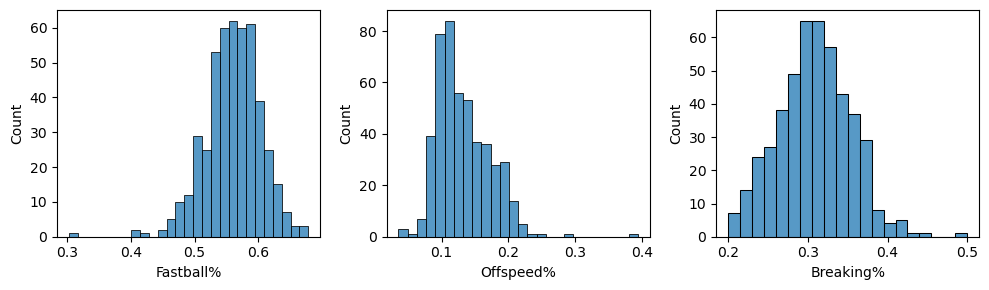

In [11]:
fig, ax = plt.subplots(1, 3, figsize=(10, 3))
sns.histplot(stats_prev['prev_FB%'], ax=ax[0])
ax[0].set_xlabel('Fastball%')

sns.histplot(stats_prev['prev_OS%'], ax=ax[1])
ax[1].set_xlabel('Offspeed%')

sns.histplot(stats_prev['prev_BB%'], ax=ax[2])
ax[2].set_xlabel('Breaking%')

fig.tight_layout()

plt.show()

### Swing Rates

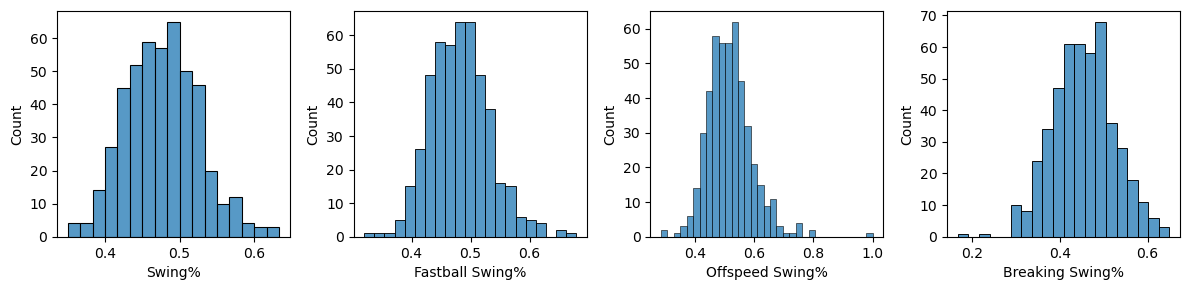

In [12]:
fig, ax = plt.subplots(1, 4, figsize=(12, 3))

sns.histplot(stats_prev['prev_swing%'], ax=ax[0])
ax[0].set_xlabel('Swing%')

sns.histplot(stats_prev['prev_FB_swing%'], ax=ax[1])
ax[1].set_xlabel('Fastball Swing%')

sns.histplot(stats_prev['prev_OS_swing%'], ax=ax[2])
ax[2].set_xlabel('Offspeed Swing%')

sns.histplot(stats_prev['prev_BB_swing%'], ax=ax[3])
ax[3].set_xlabel('Breaking Swing%')

fig.tight_layout()

plt.show()

### Whiff Rates

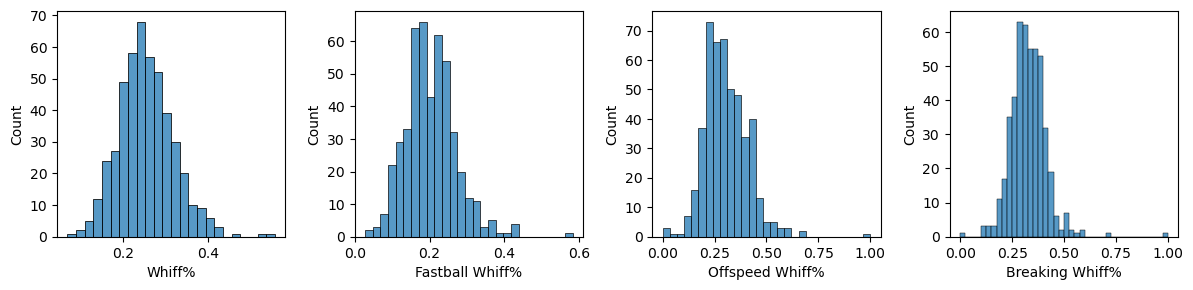

In [13]:
fig, ax = plt.subplots(1, 4, figsize=(12, 3))

sns.histplot(stats_prev['prev_whiff%'], ax=ax[0])
ax[0].set_xlabel('Whiff%')

sns.histplot(stats_prev['prev_FB_whiff%'], ax=ax[1])
ax[1].set_xlabel('Fastball Whiff%')

sns.histplot(stats_prev['prev_OS_whiff%'], ax=ax[2])
ax[2].set_xlabel('Offspeed Whiff%')

sns.histplot(stats_prev['prev_BB_whiff%'], ax=ax[3])
ax[3].set_xlabel('Breaking Whiff%')

fig.tight_layout()

plt.show()

### O-Swing Rates

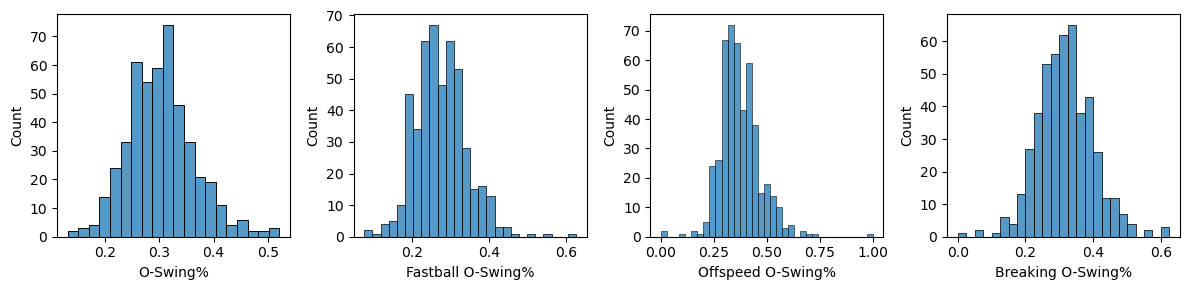

In [14]:
fig, ax = plt.subplots(1, 4, figsize=(12, 3))

sns.histplot(stats_prev['prev_oswing%'], ax=ax[0])
ax[0].set_xlabel('O-Swing%')

sns.histplot(stats_prev['prev_FB_oswing%'], ax=ax[1])
ax[1].set_xlabel('Fastball O-Swing%')

sns.histplot(stats_prev['prev_OS_oswing%'], ax=ax[2])
ax[2].set_xlabel('Offspeed O-Swing%')

sns.histplot(stats_prev['prev_BB_oswing%'], ax=ax[3])
ax[3].set_xlabel('Breaking O-Swing%')

fig.tight_layout()

plt.show()

### Z-Swing Rates

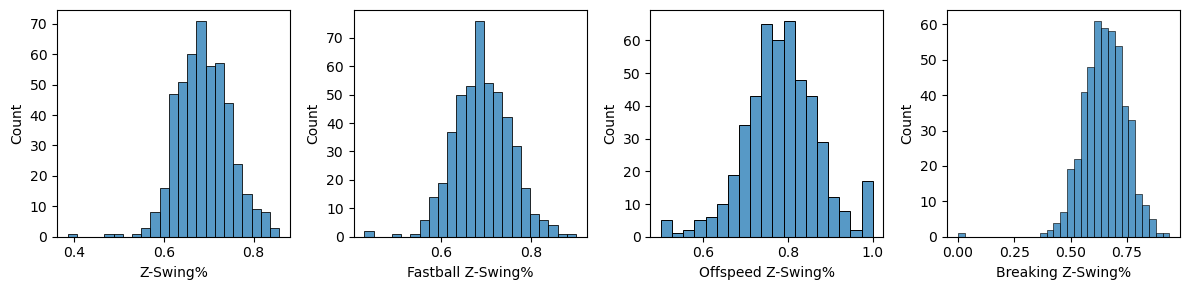

In [15]:
fig, ax = plt.subplots(1, 4, figsize=(12, 3))

sns.histplot(stats_prev['prev_zswing%'], ax=ax[0])
ax[0].set_xlabel('Z-Swing%')

sns.histplot(stats_prev['prev_FB_zswing%'], ax=ax[1])
ax[1].set_xlabel('Fastball Z-Swing%')

sns.histplot(stats_prev['prev_OS_zswing%'], ax=ax[2])
ax[2].set_xlabel('Offspeed Z-Swing%')

sns.histplot(stats_prev['prev_BB_zswing%'], ax=ax[3])
ax[3].set_xlabel('Breaking Z-Swing%')

fig.tight_layout()

plt.show()

### wOBAs

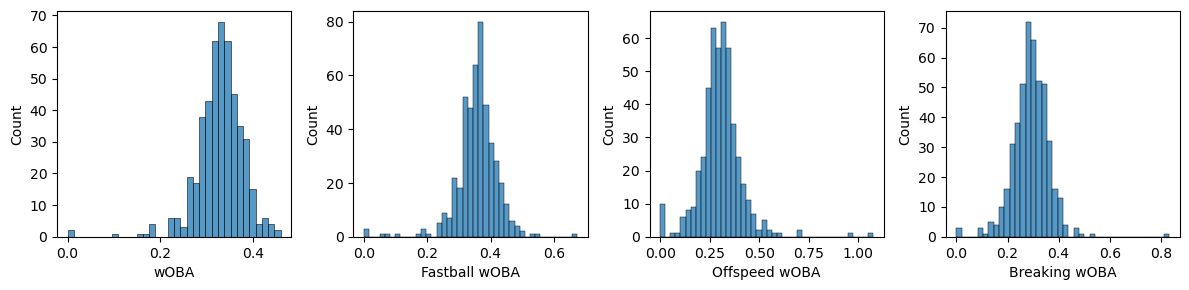

In [16]:
fig, ax = plt.subplots(1, 4, figsize=(12, 3))

sns.histplot(stats_prev['prev_woba'], ax=ax[0])
ax[0].set_xlabel('wOBA')

sns.histplot(stats_prev['prev_FB_woba'], ax=ax[1])
ax[1].set_xlabel('Fastball wOBA')

sns.histplot(stats_prev['prev_OS_woba'], ax=ax[2])
ax[2].set_xlabel('Offspeed wOBA')

sns.histplot(stats_prev['prev_BB_woba'], ax=ax[3])
ax[3].set_xlabel('Breaking wOBA')

fig.tight_layout()

plt.show()

<a id='subsection2'></a>
## Data Cleaning
The distributions above look approximately normal, so there is not much data cleaning that needs to be done. However, there were a few outliers, that I presume are due to the player only seeing a small number of pitches. For this reason, I will filter to only include players that saw 100 pitches over the course of their season. The code to do that is shown below. 

In [17]:
# remove rows with less than 100 pitches seen
stats_prev = stats_prev.loc[stats_prev['Pitches_seen']>100]
stats_prev = stats_prev.loc[stats_prev['prev_Pitches_seen']>100]

In [18]:
# remove unnecessary columns
stats_prev.drop(columns=['Pitches_seen', 'prev_Pitches_seen'], axis=1, inplace=True)

<a id='section2'></a>
# Model Creation
After I have cleaned data, I now create and tune the models. Using the features defined below, each model is first trained with default hyperparameters and evaluated. The models are then put through three steps of hyperparameter tuning, in which different parameters are tuned each time. Finally, the model is re-evaluated using the best found parameters from the hyperparameter tuning steps. A final model is then trained on the entire data set, which will be used to generate the predictions. 

### Table of Contents
- [Fastball% Model](#fastball-tuning)
- [Offspeed% Model](#offspeed-tuning)
- [Breaking% Model](#breaking-tuning)

In [19]:
FB_feats = ['prev_FB%', 'prev_swing%', 'prev_whiff%', 'prev_oswing%', 'prev_zswing%', 'prev_woba', 
            'prev_FB_swing%', 'prev_FB_whiff%', 'prev_FB_oswing%', 'prev_FB_zswing%', 'prev_FB_woba',
            'hits']

OS_feats = ['prev_OS%', 'prev_swing%', 'prev_whiff%', 'prev_oswing%', 'prev_zswing%', 'prev_woba', 
            'prev_OS_swing%', 'prev_OS_whiff%', 'prev_OS_oswing%', 'prev_OS_zswing%', 'prev_OS_woba',
            'hits']

BB_feats = ['prev_BB%', 'prev_swing%', 'prev_whiff%', 'prev_oswing%', 'prev_zswing%', 'prev_woba', 
            'prev_BB_swing%', 'prev_BB_whiff%', 'prev_BB_oswing%', 'prev_BB_zswing%', 'prev_BB_woba',
            'hits']

<a id='fastball-tuning'></a>
## Fastball% Model

### Default Model

In [20]:
# split data into input and output sets
X = stats_prev[FB_feats]
y = stats_prev['FB%']

# convert hits into hits_R, hits_L, and hits_S
X = pd.get_dummies(X, dtype=int)

# get training and testing splits
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# create and fit model with default parameters
xgb_fb = XGBRegressor(random_state=42)
xgb_fb.fit(X_train, y_train)

# get predictions for test set
FB_preds = xgb_fb.predict(X_test)

# print R2 and RMSE
print('-----FB-----')
print(f"R2 Score: {r2_score(y_test, FB_preds):.4f}")
print(f"RMSE: {root_mean_squared_error(y_test, FB_preds):.4f}")

-----FB-----
R2 Score: 0.3472
RMSE: 0.0308


### Hyperparameter Tuning

In [21]:
# create function to to hyperparameter tuning using grid search given a parameter grid and existing parameters
def tune_fb_hyperparameters(param_grid, existing_params):
    
    # add random state to parameters list
    existing_params['random_state'] = 42
    
    # split data into input and output sets
    X = pd.get_dummies(stats_prev[FB_feats], dtype=int)
    y = stats_prev['FB%']
    
    # create training and testing splits
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
    
    # create model with existing parameters
    xgb_fb = XGBRegressor(**existing_params)
    
    # define and run grid search on training data
    grid_search = GridSearchCV(
        estimator=xgb_fb,
        param_grid=param_grid,
        scoring='neg_root_mean_squared_error',
        cv=5,  
        n_jobs=-1 
    )
    grid_search.fit(X_train, y_train)

    # print the best parameters and the best score achieved
    print(f"Best parameters: {grid_search.best_params_}")
    print(f"Best cross-validation RMSE: {-grid_search.best_score_:.4f}")
    
    # return the best parameters
    return grid_search.best_params_

#### Tuning `n_estimators` and `learning_rate`

In [22]:
# define possible values for n_estimators and learning_rate
param_grid = {
    'n_estimators': [100, 150, 200, 250, 300],
    'learning_rate': [0.005, 0.01, 0.05, 0.1, 0.2]
}

# no existing parameters
existing_params = {}

# run hyperparameter tuning and get best parameters
grid_search_1_params = tune_fb_hyperparameters(param_grid, existing_params)

Best parameters: {'learning_rate': 0.1, 'n_estimators': 100}
Best cross-validation RMSE: 0.0326


#### Tuning `max_depth` and `min_child_weight`

In [23]:
# define possible values for max_depth and min_child_weight
param_grid = {
    'max_depth': [3, 4, 5, 6, 7],
    'min_child_weight': [5, 7, 9, 11, 13] 
}

# use best parameters found from first grid search
existing_params = grid_search_1_params

# run hyperparameter tuning and get best parameters
grid_search_2_params = tune_fb_hyperparameters(param_grid, existing_params)

Best parameters: {'max_depth': 7, 'min_child_weight': 13}
Best cross-validation RMSE: 0.0306


#### Tuning `gamma`

In [24]:
# define possible values for gamma
param_grid = {
    'gamma': [0, 0.1, 0.2, 0.5, 1, 2, 5] 
}

# use best parameters found from first and secon grid searches
existing_params = grid_search_1_params | grid_search_2_params

# run hyperparameter tuning and get best parameters
grid_search_3_params = tune_fb_hyperparameters(param_grid, existing_params)

Best parameters: {'gamma': 0}
Best cross-validation RMSE: 0.0306


### Final Tuned Model

In [25]:
# split data into input and output sets
X = stats_prev[FB_feats]
y = stats_prev['FB%']

# convert hits into hits_R, hits_L, and hits_S
X = pd.get_dummies(X, dtype=int)

# get training and testing splits
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# get optimal parameters from the grid searches
best_params = grid_search_1_params | grid_search_2_params | grid_search_3_params

# create and fit model with default parameters
xgb_fb = XGBRegressor(**best_params)
xgb_fb.fit(X_train, y_train)

# get predictions for test set
FB_preds = xgb_fb.predict(X_test)

# print R2 and RMSE
print('-----FB-----')
print(f"R2 Score: {r2_score(y_test, FB_preds):.4f}")
print(f"RMSE: {root_mean_squared_error(y_test, FB_preds):.4f}")

-----FB-----
R2 Score: 0.4222
RMSE: 0.0290


In [26]:
# tune final version on entire data set
xgb_fb_final = XGBRegressor(**best_params)
xgb_fb_final.fit(X, y)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=7, max_leaves=None,
             min_child_weight=13, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

<a id='offspeed-tuning'></a>
## Offspeed% Model

### Default Model

In [27]:
# split data into input and output sets
X = stats_prev[OS_feats]
y = stats_prev['OS%']

# convert hits into hits_R, hits_L, and hits_S
X = pd.get_dummies(X, dtype=int)

# get training and testing splits
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# create and fit model with default parameters
xgb_os = XGBRegressor(random_state=42)
xgb_os.fit(X_train, y_train)

# get predictions for test set
OS_preds = xgb_os.predict(X_test)

# print R2 and RMSE
print('-----FB-----')
print(f"R2 Score: {r2_score(y_test, OS_preds):.4f}")
print(f"RMSE: {root_mean_squared_error(y_test, OS_preds):.4f}")

-----FB-----
R2 Score: 0.6553
RMSE: 0.0247


### Hyperparameter Tuning

In [28]:
# create function to to hyperparameter tuning using grid search given a parameter grid and existing parameters
def tune_os_hyperparameters(param_grid, existing_params):
    
    # add random state to parameters list
    existing_params['random_state'] = 42
    
    # split data into input and output sets
    X = pd.get_dummies(stats_prev[OS_feats], dtype=int)
    y = stats_prev['OS%']
    
    # create training and testing splits
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
    
    # create model with existing parameters
    xgb_os = XGBRegressor(**existing_params)
    
    # define and run grid search on training data
    grid_search = GridSearchCV(
        estimator=xgb_os,
        param_grid=param_grid,
        scoring='neg_root_mean_squared_error',
        cv=5,  
        n_jobs=-1 
    )
    grid_search.fit(X_train, y_train)

    # print the best parameters and the best score achieved
    print(f"Best parameters: {grid_search.best_params_}")
    print(f"Best cross-validation RMSE: {-grid_search.best_score_:.4f}")
    
    # return the best parameters
    return grid_search.best_params_

#### Tuning `n_estimators` and `learning_rate`

In [29]:
# define possible values for n_estimators and learning_rate
param_grid = {
    'n_estimators': [100, 150, 200, 250, 300],
    'learning_rate': [0.005, 0.01, 0.05, 0.1, 0.2]
}

# no existing parameters
existing_params = {}

# run hyperparameter tuning and get best parameters
grid_search_1_params = tune_os_hyperparameters(param_grid, existing_params)

Best parameters: {'learning_rate': 0.05, 'n_estimators': 100}
Best cross-validation RMSE: 0.0232


#### Tuning `max_depth` and `min_child_weight`

In [ ]:
# define possible values for max_depth and min_child_weight
param_grid = {
    'max_depth': [3, 4, 5, 6, 7],
    'min_child_weight': [5, 7, 9, 11, 13] 
}

# use best parameters found from first grid search
existing_params = grid_search_1_params

# run hyperparameter tuning and get best parameters
grid_search_2_params = tune_os_hyperparameters(param_grid, existing_params)

#### Tuning `gamma`

In [ ]:
# define possible values for gamma
param_grid = {
    'gamma': [0, 0.1, 0.2, 0.5, 1, 2, 5] 
}

# use best parameters found from first and secon grid searches
existing_params = grid_search_1_params | grid_search_2_params

# run hyperparameter tuning and get best parameters
grid_search_3_params = tune_os_hyperparameters(param_grid, existing_params)

### Final Tuned Model

In [ ]:
# split data into input and output sets
X = stats_prev[OS_feats]
y = stats_prev['OS%']

# convert hits into hits_R, hits_L, and hits_S
X = pd.get_dummies(X, dtype=int)

# get training and testing splits
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# get optimal parameters from the grid searches
best_params = grid_search_1_params | grid_search_2_params | grid_search_3_params

# create and fit model with default parameters
xgb_os = XGBRegressor(**best_params)
xgb_os.fit(X_train, y_train)

# get predictions for test set
OS_preds = xgb_os.predict(X_test)

# print R2 and RMSE
print('-----FB-----')
print(f"R2 Score: {r2_score(y_test, OS_preds):.4f}")
print(f"RMSE: {root_mean_squared_error(y_test, OS_preds):.4f}")

In [ ]:
# tune final version on entire data set
xgb_os_final = XGBRegressor(**best_params)
xgb_os_final.fit(X, y)

<a id='breaking-tuning'></a>
## Breaking% Model

### Default Model

In [ ]:
# split data into input and output sets
X = stats_prev[BB_feats]
y = stats_prev['BB%']

# convert hits into hits_R, hits_L, and hits_S
X = pd.get_dummies(X, dtype=int)

# get training and testing splits
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# create and fit model with default parameters
xgb_bb = XGBRegressor(random_state=42)
xgb_bb.fit(X_train, y_train)

# get predictions for test set
BB_preds = xgb_bb.predict(X_test)

# print R2 and RMSE
print('-----FB-----')
print(f"R2 Score: {r2_score(y_test, BB_preds):.4f}")
print(f"RMSE: {root_mean_squared_error(y_test, BB_preds):.4f}")

### Hyperparameter Tuning

In [ ]:
# create function to to hyperparameter tuning using grid search given a parameter grid and existing parameters
def tune_bb_hyperparameters(param_grid, existing_params):
    
    # add random state to parameters list
    existing_params['random_state'] = 42
    
    # split data into input and output sets
    X = pd.get_dummies(stats_prev[BB_feats], dtype=int)
    y = stats_prev['BB%']
    
    # create training and testing splits
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
    
    # create model with existing parameters
    xgb_bb = XGBRegressor(**existing_params)
    
    # define and run grid search on training data
    grid_search = GridSearchCV(
        estimator=xgb_bb,
        param_grid=param_grid,
        scoring='neg_root_mean_squared_error',
        cv=5,  
        n_jobs=-1 
    )
    grid_search.fit(X_train, y_train)

    # print the best parameters and the best score achieved
    print(f"Best parameters: {grid_search.best_params_}")
    print(f"Best cross-validation RMSE: {-grid_search.best_score_:.4f}")
    
    # return the best parameters
    return grid_search.best_params_

#### Tuning `n_estimators` and `learning_rate`

In [ ]:
# define possible values for n_estimators and learning_rate
param_grid = {
    'n_estimators': [100, 150, 200, 250, 300],
    'learning_rate': [0.005, 0.01, 0.05, 0.1, 0.2]
}

# no existing parameters
existing_params = {}

# run hyperparameter tuning and get best parameters
grid_search_1_params = tune_bb_hyperparameters(param_grid, existing_params)

#### Tuning `max_depth` and `min_child_weight`

In [ ]:
# define possible values for max_depth and min_child_weight
param_grid = {
    'max_depth': [3, 4, 5, 6, 7],
    'min_child_weight': [5, 7, 9, 11, 13] 
}

# use best parameters found from first grid search
existing_params = grid_search_1_params

# run hyperparameter tuning and get best parameters
grid_search_2_params = tune_bb_hyperparameters(param_grid, existing_params)

#### Tuning `gamma`

In [ ]:
# define possible values for gamma
param_grid = {
    'gamma': [0, 0.1, 0.2, 0.5, 1, 2, 5] 
}

# use best parameters found from first and secon grid searches
existing_params = grid_search_1_params | grid_search_2_params

# run hyperparameter tuning and get best parameters
grid_search_3_params = tune_bb_hyperparameters(param_grid, existing_params)

### Final Tuned Model

In [ ]:
# split data into input and output sets
X = stats_prev[BB_feats]
y = stats_prev['BB%']

# convert hits into hits_R, hits_L, and hits_S
X = pd.get_dummies(X, dtype=int)

# get training and testing splits
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# get optimal parameters from the grid searches
best_params = grid_search_1_params | grid_search_2_params | grid_search_3_params

# create and fit model with default parameters
xgb_bb = XGBRegressor(**best_params)
xgb_bb.fit(X_train, y_train)

# get predictions for test set
BB_preds = xgb_bb.predict(X_test)

# print R2 and RMSE
print('-----FB-----')
print(f"R2 Score: {r2_score(y_test, BB_preds):.4f}")
print(f"RMSE: {root_mean_squared_error(y_test, BB_preds):.4f}")

In [ ]:
# tune final version on entire data set
xgb_bb_final = XGBRegressor(**best_params)
xgb_bb_final.fit(X, y)

<a id='section3'></a>
# Generate Predictions
The last step is to run the models on each pitch type and aggregate the results. The code below demonstrates this process. 

In [ ]:
# get all players who do not appear in the stats_df for 2023
missing_players = set(df['BATTER_ID'].drop_duplicates()) - set(stats_df.loc[stats_df['GAME_YEAR']==2023, 'BATTER_ID'])
missing_players_df = stats_df.loc[(stats_df['BATTER_ID'].isin(missing_players)) & (stats_df['GAME_YEAR']==2022), :]

# add the missing players to the 2023 df and rename columns
preds_df = pd.concat([stats_df.loc[stats_df['GAME_YEAR']==2023, :], missing_players_df], axis=0).reset_index(drop=True)
preds_df = preds_df.rename(columns={col:'prev_'+col for col in preds_df.columns[2:-2]})

# merge in hits and convert it to hits_R, hits_L, and hits_S, then remove hits
preds_df = pd.concat([preds_df, pd.get_dummies(preds_df[['BATTER_ID', 'GAME_YEAR']].merge(stats_df[['BATTER_ID', 'GAME_YEAR', 'hits']], on=['BATTER_ID', 'GAME_YEAR'])['hits'], prefix='hits', dtype=int)], axis=1)
preds_df = preds_df.drop(columns=['hits'])

# get predictions for each pitch classification
preds_df['fb_pred'] = xgb_fb.predict(preds_df[xgb_fb.get_booster().feature_names])
preds_df['os_pred'] = xgb_os.predict(preds_df[xgb_os.get_booster().feature_names])
preds_df['bb_pred'] = xgb_bb.predict(preds_df[xgb_bb.get_booster().feature_names])

# scale predictions to add to one
preds_df[['PITCH_TYPE_FB', 'PITCH_TYPE_OS', 'PITCH_TYPE_BB']] = preds_df[['fb_pred', 'os_pred', 'bb_pred']].div(preds_df[['fb_pred', 'os_pred', 'bb_pred']].sum(axis=1), axis=0)

# add player name to predictions
preds_df = preds_df.merge(df[['BATTER_ID', 'PLAYER_NAME']].drop_duplicates(), on='BATTER_ID')

# show prediction dataframe
preds_df[['BATTER_ID', 'PLAYER_NAME', 'PITCH_TYPE_FB', 'PITCH_TYPE_OS', 'PITCH_TYPE_BB']].head()

In [ ]:
preds_df[['BATTER_ID', 'PLAYER_NAME', 'PITCH_TYPE_FB', 'PITCH_TYPE_OS', 'PITCH_TYPE_BB']].to_csv('submission.csv')

# Export Products
Export all the necessary models/data files to run the dashboard.

In [ ]:
# export fastball model
with open('xgb_fb.pkl', 'wb') as file:
    pickle.dump(xgb_fb_final, file)

# export offspeed model
with open('xgb_os.pkl', 'wb') as file:
    pickle.dump(xgb_os_final, file)

# export breaking model
with open('xgb_bb.pkl', 'wb') as file:
    pickle.dump(xgb_bb_final, file)

In [ ]:
# export batter statistics for 2023
stats_df_2023 = stats_df.loc[stats_df['GAME_YEAR']==2023, :].rename(columns={col:'prev_'+col for col in stats_df.columns[2:-2]})
stats_df_2023 = stats_df_2023.merge(df[['BATTER_ID', 'PLAYER_NAME']].drop_duplicates(), on='BATTER_ID')
stats_df_2023.to_csv('stats_df_2023.csv', index=False)